In [1]:
# ops
import pandas as pd 
from sklearn.cross_validation import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%pylab inline

# ml 
from sklearn import preprocessing
from sklearn import cluster, tree
from sklearn.decomposition import PCA

/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [47]:

# python 3 

# ops
import pandas as pd 
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.externals import joblib

# ml 
from sklearn import preprocessing
from sklearn import cluster, tree
from sklearn.decomposition import PCA



# -------------------------------------
# help function 
# data preprocess 


def get_data():
    route='datasets/ml-latest-small/'
    #df_movie = pd.read_csv(route +'movies.csv')
    df_ratings = pd.read_csv(route +'ratings.csv')
    return df_ratings

def data_preprocess(df):
    df['view_count']=df.groupby(['userId','movieId']).count().reset_index()['rating']
    movie_grouped = df.groupby(['movieId']).agg({'view_count': 'count'}).reset_index()
    grouped_sum = movie_grouped['view_count'].sum()
    movie_grouped['percentage']  = movie_grouped['view_count'].div(grouped_sum)*100
    movie_grouped.sort_values(['view_count', 'movieId'], ascending = [0,1])
    return movie_grouped


def get_train_test_data(df):
	train_data, test_data = train_test_split(df, test_size = 0.20, random_state=0)
	return train_data, test_data


def fix_extreme_value(column):
    print (column.max())
    fixed_column = [x if x < 100 else column.mean()  for x in column] 
    return  fixed_column


def get_user_movie_metrix(df):
	cols = ['userId', 'movieId', 'rating']
	df_ = df[cols]
	df_ratings_grouped = df_.groupby(['userId', 'movieId']).sum()
	df_ratings_pivot = pd.pivot_table(df_ratings_grouped,columns=['movieId'],index=['userId'],aggfunc=np.sum)
	# approach 1 : fill n/a data with 0 
	df_ratings_pivot_ = df_ratings_pivot.fillna(0)
	df_ratings_pivot_.columns= list(set(df_.movieId))
	df_ratings_pivot_.reset_index()
	# approach 2 : fill n/a data with mean 
	#df_ratings_pivot_ = df_ratings_pivot.fillna(0)
	
	X = df_ratings_pivot_.iloc[:,1:].fillna(0)
	df_ratings_pivot_std = df_ratings_pivot_.copy()
	# standardize 
	for i in X:
		df_ratings_pivot_std[i] = preprocessing.scale(df_ratings_pivot_std[i])
	# pca : modify dimension from N  ->  2 
	# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
	# need to find tuned pca dimension below 

	pca = PCA(n_components=2)
	pca.fit(df_ratings_pivot_std)
	ratings_pivot_std_pca =  pca.fit_transform(df_ratings_pivot_std)
	# fix extreme value (for clustering)
	ratings_pivot_std_pca_ = pd.DataFrame(ratings_pivot_std_pca)
	# set userID as index for output clustering group outcome
	ratings_pivot_std_pca_['userId'] = ratings_pivot_std_pca_.index+1
	ratings_pivot_std_pca_ = ratings_pivot_std_pca_.set_index('userId')
	ratings_pivot_std_pca_[0] = fix_extreme_value(ratings_pivot_std_pca_[0])
	ratings_pivot_std_pca_[1] = fix_extreme_value(ratings_pivot_std_pca_[1])
	print (ratings_pivot_std_pca_.max())
	
	#print (df_ratings_pivot_)
	#print (df_ratings_pivot_std)
	return df_ratings_pivot_, df_ratings_pivot_std, ratings_pivot_std_pca_


# -------------------------------------
# model 



def KNN_model(user_movie_metrix,df_ratings_pivot):
	# kmeans clustering 
	kmean = cluster.KMeans(n_clusters=10, max_iter=300, random_state=4000)
	kmean.fit(user_movie_metrix)
	# add lebel to user table 
	df_ratings_pivot['group'] = kmean.labels_
	#df_train['group'] = kmean.labels_ 
	print ('*'*10)
	print ('*** Cluster output : ')
	print (df_ratings_pivot)
	print ('*** User group  : ')
	print (df_ratings_pivot.group.value_counts())
	print ('*'*10)
	return df_ratings_pivot





In [54]:
############ run all together ############

In [49]:

df_ratings = get_data()
# get user-movie matrix
df_ratings_pivot_, df_ratings_pivot_std, ratings_pivot_std_pca_ = get_user_movie_metrix(df_ratings)
# KNN modeling  
df_ratings_pivot_group = KNN_model(ratings_pivot_std_pca_,df_ratings_pivot_)
### todo : filter outler / refine df_ratings_pivot_std (user-movie matrix)




664.3458312593922
449.55824293912514
0    93.469090
1    70.752452
dtype: float64
**********
*** Cluster output : 
          1    2    3    4    5    6    7    8    9   10  ...    65465  98243  \
userId                                                    ...                   
1       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   
2       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  ...      0.0    0.0   
3       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   
4       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  ...      0.0    0.0   
5       0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   
6       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   
7       3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  ...      0.0    0.0   
8       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   
9       4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0

In [128]:
xx = df_ratings_pivot.copy()
df_ratings_pivot.head(3)

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    4.0   
3          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

         ...                                                                   \
movieId  ...   161084 161155 161594 161830 161918 161944 162376 162542 162672   
userId   ...                                                                    
1        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 163949  
userId          
1          NaN  
2          NaN  
3          NaN  

[3 rows x 9066 columns]

In [135]:
xx.iloc[0]

        movieId
rating  1         NaN
        2         NaN
        3         NaN
        4         NaN
        5         NaN
        6         NaN
        7         NaN
        8         NaN
        9         NaN
        10        NaN
        11        NaN
        12        NaN
        13        NaN
        14        NaN
        15        NaN
        16        NaN
        17        NaN
        18        NaN
        19        NaN
        20        NaN
        21        NaN
        22        NaN
        23        NaN
        24        NaN
        25        NaN
        26        NaN
        27        NaN
        28        NaN
        29        NaN
        30        NaN
                   ..
        158238    NaN
        158314    NaN
        158528    NaN
        158956    NaN
        159093    NaN
        159462    NaN
        159690    NaN
        159755    NaN
        159858    NaN
        159972    NaN
        160080    NaN
        160271    NaN
        160438    NaN
        160440  

In [145]:
xx.iloc[1]

        movieId
rating  1          NaN
        2          NaN
        3          NaN
        4          NaN
        5          NaN
        6          NaN
        7          NaN
        8          NaN
        9          NaN
        10         4.0
        11         NaN
        12         NaN
        13         NaN
        14         NaN
        15         NaN
        16         NaN
        17         5.0
        18         NaN
        19         NaN
        20         NaN
        21         NaN
        22         NaN
        23         NaN
        24         NaN
        25         NaN
        26         NaN
        27         NaN
        28         NaN
        29         NaN
        30         NaN
                  ... 
        158238     NaN
        158314     NaN
        158528     NaN
        158956     NaN
        159093     NaN
        159462     NaN
        159690     NaN
        159755     NaN
        159858     NaN
        159972     NaN
        160080     NaN
        160271    

In [153]:
xx.head(3)

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    4.0   
3          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

         ...                                                                   \
movieId  ...   161084 161155 161594 161830 161918 161944 162376 162542 162672   
userId   ...                                                                    
1        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 163949  
userId          
1          NaN  
2          NaN  
3          NaN  

[3 rows x 9066 columns]

In [160]:
xx.iloc[:-1].mean(axis=1)

userId
1      2.550000
2      3.486842
3      3.568627
4      4.348039
5      3.910000
6      3.261364
7      3.465909
8      3.866379
9      3.755556
10     3.695652
11     4.078947
12     2.754098
13     3.745283
14     2.950000
15     2.621765
16     4.120690
17     3.743802
18     3.235294
19     3.534279
20     3.290816
21     3.506173
22     3.275000
23     3.632920
24     3.666667
25     3.115385
26     3.468023
27     3.826087
28     4.280000
29     2.863636
30     3.765084
         ...   
641    3.900000
642    3.916667
643    3.395833
644    3.743590
645    3.683333
646    4.130178
647    4.273333
648    3.628906
649    3.511111
650    3.310345
651    3.900000
652    4.220974
653    4.000000
654    4.068690
655    4.085714
656    4.523438
657    3.500000
658    4.350000
659    3.387324
660    4.168478
661    3.833333
662    3.396552
663    3.730769
664    3.796724
665    3.285714
666    2.950000
667    3.647059
668    3.750000
669    3.351351
670    3.806452
Length: 670, dtyp

In [174]:
xx

rating                                                              \
movieId    1         2         3         4         5         6         7        
userId                                                                          
1        2.550000  2.550000  2.550000  2.550000  2.550000  2.550000  2.550000   
2        3.486842  3.486842  3.486842  3.486842  3.486842  3.486842  3.486842   
3        3.568627  3.568627  3.568627  3.568627  3.568627  3.568627  3.568627   
4        4.348039  4.348039  4.348039  4.348039  4.348039  4.348039  4.348039   
5        3.910000  3.910000  4.000000  3.910000  3.910000  3.910000  3.910000   
6        3.261364  3.261364  3.261364  3.261364  3.261364  3.261364  3.261364   
7        3.000000  3.465909  3.465909  3.465909  3.465909  3.465909  3.465909   
8        3.866379  3.866379  3.866379  3.866379  3.866379  3.866379  3.866379   
9        4.000000  3.755556  3.755556  3.755556  3.755556  3.755556  3.755556   
10       3.695652  3.695652  3.695652  3.695652  3.695652  3.695652  3.695652   
11       4.078947  4.078947  4.078947  4.078947  4.078947  4.078947  4.078947   
12       2.754098  2.754098  2.754098  2.754098  2.754098  2.754098  2.754098   
13       5.000000  3.745283  3.745283  3.745283  3.745283  3.745283  3.745283   
14       2.950000  2.950000  2.950000  2.950000  2.950000  2.950000  2.950000   
15       2.000000  2.000000  2.621765  2.621765  4.500000  4.000000  2.621765   
16       4.120690  4.120690  4.120690  4.120690  4.120690  4.120690  4.120690   
17       3.743802  3.743802  3.743802  3.743802  3.743802  4.500000  3.743802   
18       3.235294  3.235294  3.235294  3.235294  3.000000  4.000000  3.000000   
19       3.000000  3.000000  3.000000  3.000000  3.534279  3.000000  3.000000   
20       3.500000  3.290816  3.290816  3.290816  3.290816  3.290816  3.290816   
21       3.506173  3.506173  3.506173  3.506173  3.506173  3.506173  3.506173   
22       3.275000  3.275000  3.275000  3.275000  3.275000  3.275000  3.275000   
23       3.000000  3.632920  3.632920  3.632920  3.632920  3.500000  3.632920   
24       3.666667  3.666667  3.666667  3.666667  3.666667  5.000000  3.666667   
25       3.115385  3.115385  3.000000  3.115385  3.115385  3.115385  3.115385   
26       5.000000  3.468023  3.468023  3.468023  3.468023  3.468023  3.468023   
27       3.826087  3.826087  3.826087  3.826087  3.826087  3.826087  3.826087   
28       4.280000  4.280000  4.280000  4.280000  4.280000  4.280000  4.280000   
29       2.863636  2.863636  2.863636  2.863636  2.863636  2.863636  2.863636   
30       4.000000  2.000000  3.765084  3.765084  3.765084  4.000000  3.765084   
...           ...       ...       ...       ...       ...       ...       ...   
642      3.916667  3.916667  3.916667  3.916667  3.916667  3.916667  3.916667   
643      3.395833  3.395833  3.395833  3.395833  3.395833  3.395833  3.395833   
644      3.743590  3.743590  3.743590  1.000000  3.743590  3.743590  3.743590   
645      3.683333  3.683333  3.683333  3.683333  3.683333  3.683333  3.683333   
646      5.000000  4.130178  5.000000  4.130178  4.130178  4.130178  4.130178   
647      4.000000  4.273333  4.273333  4.273333  4.273333  4.000000  4.273333   
648      3.628906  3.628906  3.628906  3.628906  3.628906  4.000000  3.628906   
649      4.000000  3.511111  3.511111  3.000000  3.511111  3.511111  3.511111   
650      3.310345  3.310345  3.000000  1.000000  3.000000  3.310345  3.310345   
651      3.900000  3.900000  3.900000  3.900000  3.900000  3.900000  3.900000   
652      4.220974  4.220974  4.220974  4.220974  4.220974  4.220974  4.220974   
653      4.000000  4.000000  4.000000  4.000000  4.000000  4.000000  4.000000   
654      5.000000  3.000000  4.068690  4.068690  4.000000  4.068690  4.068690   
655      4.085714  4.000000  4.085714  4.085714  4.085714  4.085714  4.085714   
656      4.523438  4.523438  4.523438  4.523438  4.523438  4.523438  4.523438   
657      3.500000  3.500000  3.500000  3.5

In [173]:
for index, row in xx.iterrows():
    row_mean = xx.iloc[index-1].mean()
    print (row_mean)
    xx.iloc[index-1].fillna(row_mean, inplace=True)
    #print (xx.iloc[index])

2.55
3.486842105263158
3.5686274509803924
4.348039215686274
3.91
3.2613636363636362
3.465909090909091
3.8663793103448274
3.7555555555555555
3.6956521739130435
4.078947368421052
2.7540983606557377
3.7452830188679247
2.95
2.6217647058823528
4.120689655172414
3.743801652892562
3.235294117647059
3.534278959810875
3.2908163265306123
3.506172839506173
3.275
3.6329201101928374
3.6666666666666665
3.1153846153846154
3.4680232558139537
3.8260869565217392
4.28
2.8636363636363638
3.765084075173096
4.166666666666667
3.6666666666666665
3.2753623188405796
3.935828877005348
2.4
3.6153846153846154
4.0625
4.292792792792793
3.7903225806451615
4.511627906976744
3.8668341708542715
4.014285714285714
3.0
3.36
3.619047619047619
4.948717948717949
3.8684210526315788
3.5146198830409356
3.4646464646464645
3.282608695652174
3.967741935483871
3.6911764705882355
2.782608695652174
3.7954545454545454
3.6315789473684212
3.6149425287356323
3.9569377990430623
3.410958904109589
3.0833333333333335
4.181818181818182
3.27409

4.290322580645161
4.2407407407407405
3.8181818181818183
3.5319148936170213
4.323529411764706
3.4630872483221475
4.285714285714286
3.572842998585573
4.403125
3.3733766233766236
4.204081632653061
3.166
4.035714285714286
3.796875
3.6594202898550723
4.111111111111111
3.174074074074074
3.3976377952755907
3.5298013245033113
3.8076923076923075
2.977272727272727
3.676470588235294
3.3496932515337425
3.6402640264026402
3.015873015873016
3.871559633027523
3.996742671009772
3.6
4.0
3.7
3.2758620689655173
3.857142857142857
4.3478260869565215
4.472014925373134
3.902173913043478
4.415384615384616
3.3667921371810956
3.3768115942028984
3.090909090909091
3.585185185185185
3.4
2.710526315789474
4.0
3.359375
3.1733333333333333
4.4
2.7045454545454546
4.339534883720931
4.4186046511627906
3.91
3.597972972972973
4.017786561264822
3.901898734177215
3.5524625267665955
3.7037037037037037
4.409090909090909
4.3088235294117645
4.135135135135135
4.105882352941176
3.66015625
3.652542372881356
3.6792452830188678
3.526

In [127]:
#df_ratings.head(30)

In [124]:
df_ratings_pivot.mean(axis=1)

userId
1      2.550000
2      3.486842
3      3.568627
4      4.348039
5      3.910000
6      3.261364
7      3.465909
8      3.866379
9      3.755556
10     3.695652
11     4.078947
12     2.754098
13     3.745283
14     2.950000
15     2.621765
16     4.120690
17     3.743802
18     3.235294
19     3.534279
20     3.290816
21     3.506173
22     3.275000
23     3.632920
24     3.666667
25     3.115385
26     3.468023
27     3.826087
28     4.280000
29     2.863636
30     3.765084
         ...   
642    3.916667
643    3.395833
644    3.743590
645    3.683333
646    4.130178
647    4.273333
648    3.628906
649    3.511111
650    3.310345
651    3.900000
652    4.220974
653    4.000000
654    4.068690
655    4.085714
656    4.523438
657    3.500000
658    4.350000
659    3.387324
660    4.168478
661    3.833333
662    3.396552
663    3.730769
664    3.796724
665    3.285714
666    2.950000
667    3.647059
668    3.750000
669    3.351351
670    3.806452
671    3.917391
Length: 671, dtyp

In [118]:
df_ratings_pivot_

,1,2,3,4,5,6,7,8,9,10,...,65465,98243,131013,32728,32735,32743,98279,65514,98296,group
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
7,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [114]:
list(set(df_ratings_pivot_group.group))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [62]:
df_ratings_pivot_group.head(3)

,1,2,3,4,5,6,7,8,9,10,...,65465,98243,131013,32728,32735,32743,98279,65514,98296,group
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [63]:
len(df_ratings_pivot_group.columns)

9067

In [105]:
# top 10 movies in group (mean rating)
print ('---------- recommend movie : ----------')

print ('movie id ,  rating')
df_ratings_pivot_group[df_ratings_pivot_group.group==9]\
                      .mean(axis=0)\
                      .sort_values(ascending=False)\
                      .head(11)
                      
                     

---------- recommend movie : ----------
movie id ,  rating


group    9.000000
296      1.624339
278      1.485450
334      1.428571
547      1.355820
446      1.138889
241      1.130952
494      1.089947
1        0.949735
544      0.919312
102      0.903439
dtype: float64

In [116]:
for group_ in list(set(df_ratings_pivot_group.group)):
    print (group_)

0
1
2
3
4
5
6
7
8
9


In [117]:
# top 10 movies in group (mean rating)

for group_ in list(set(df_ratings_pivot_group.group)):
    print ('---------- recommend movie : ----------')
    print ('group = ', group_)
    print ('movie id ,  rating')
    print (df_ratings_pivot_group[df_ratings_pivot_group.group==group_]\
                          .iloc[:,:-1]\
                          .mean(axis=0)\
                          .sort_values(ascending=False)\
                          .head(10))

                     

---------- recommend movie : ----------
group =  0
movie id ,  rating
334      2.600629
296      2.481132
278      2.377358
2347     2.327044
241      2.238994
547      2.166667
33830    1.955975
1066     1.899371
1153     1.899371
2586     1.823899
dtype: float64
---------- recommend movie : ----------
group =  1
movie id ,  rating
278      4.666667
66297    4.366667
1066     4.266667
241      4.233333
46       4.000000
547      4.000000
1082     3.966667
296      3.900000
1153     3.866667
941      3.866667
dtype: float64
---------- recommend movie : ----------
group =  2
movie id ,  rating
98296     5.0
2078      5.0
110352    5.0
2067      5.0
2063      5.0
100365    5.0
2032      5.0
110461    5.0
2006      5.0
1993      5.0
dtype: float64
---------- recommend movie : ----------
group =  3
movie id ,  rating
2347     4.625
4459     4.500
33830    4.500
241      4.500
1079     4.500
69908    4.250
5141     4.250
99005    4.000
446      4.000
8256     4.000
dtype: float64
----------

In [53]:
############ run step by step ############

In [3]:
df_ratings = get_data()
cols = ['userId', 'movieId', 'rating']
df_ratings_ = df_ratings[cols]
df_ratings_grouped = df_ratings_.groupby(['userId', 'movieId']).sum()#.reset_index()
df_ratings_pivot = pd.pivot_table(df_ratings_grouped,columns=['movieId'],index=['userId'],aggfunc=np.sum)
# approach 1 : fill n/a data with 0 
df_ratings_pivot_ = df_ratings_pivot.fillna(0)
df_ratings_pivot_.columns= list(set(df_ratings_.movieId))
df_ratings_pivot_.reset_index()
# approach 1 : fill n/a data mean 
#df_ratings_pivot_ = df_ratings_pivot.fillna(0)


#X = df_ratings_pivot_.iloc[:,1:].fillna(0)
X = df_ratings_pivot_.iloc[:,:].fillna(0)
df_ratings_pivot_std = df_ratings_pivot_.copy()
# standardize 
for i in X:
    df_ratings_pivot_std[i] = preprocessing.scale(df_ratings_pivot_std[i])



In [4]:
df_ratings_pivot_.describe()

,1,2,3,4,5,6,7,8,9,10,...,98230,65465,98243,131013,32728,32735,32743,98279,65514,98296
count,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.00000,671.000000,...,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000
mean,1.425484,0.542474,0.277943,0.046200,0.272727,0.602086,0.259314,0.028316,0.09389,0.627422,...,0.003726,0.000745,0.004471,0.001490,0.002235,0.007452,0.006706,0.007452,0.004471,0.007452
std,1.957296,1.294673,0.957620,0.352111,0.944419,1.444112,0.937908,0.350824,0.55326,1.371542,...,0.096511,0.019302,0.115814,0.038605,0.057907,0.193023,0.173721,0.193023,0.115814,0.193023
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,5.000000,5.000000,3.500000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,...,2.500000,0.500000,3.000000,1.000000,1.500000,5.000000,4.500000,5.000000,3.000000,5.000000


In [5]:
df_ratings_pivot_std

,1,2,3,4,5,6,7,8,9,10,...,98230,65465,98243,131013,32728,32735,32743,98279,65514,98296
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.728836,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,-0.457798,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633
2,-0.728836,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,2.460803,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633
3,-0.728836,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,-0.457798,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633
4,-0.728836,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,2.460803,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633
5,-0.728836,-0.419317,3.889680,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,-0.457798,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633
6,-0.728836,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,-0.457798,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633
7,0.805034,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,1.731152,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633
8,-0.728836,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,-0.457798,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633
9,1.316324,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,-0.457798,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633


In [6]:
df_ratings_pivot_std[10].max()

3.1904528394355167

In [7]:
df_ratings_pivot_std.describe()

,1,2,3,4,5,6,7,8,9,10,...,98230,65465,98243,131013,32728,32735,32743,98279,65514,98296
count,671.000000,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,671.000000,6.710000e+02,6.710000e+02,...,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02,6.710000e+02
mean,0.000000,4.235724e-17,2.382595e-17,-1.058931e-17,5.294655e-18,-2.978244e-18,-7.743433e-17,0.000000,3.706259e-17,-8.471448e-17,...,-2.117862e-17,-1.588397e-17,-7.941983e-18,-2.117862e-17,-2.647328e-17,-5.294655e-18,-2.647328e-18,-2.647328e-17,-2.647328e-17,-2.117862e-17
std,1.000746,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746,1.000746e+00,1.000746e+00,...,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00,1.000746e+00
min,-0.728836,-4.193171e-01,-2.904606e-01,-1.313058e-01,-2.889933e-01,-4.172362e-01,-2.766881e-01,-0.080773,-1.698292e-01,-4.577984e-01,...,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02
25%,-0.728836,-4.193171e-01,-2.904606e-01,-1.313058e-01,-2.889933e-01,-4.172362e-01,-2.766881e-01,-0.080773,-1.698292e-01,-4.577984e-01,...,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02
50%,-0.728836,-4.193171e-01,-2.904606e-01,-1.313058e-01,-2.889933e-01,-4.172362e-01,-2.766881e-01,-0.080773,-1.698292e-01,-4.577984e-01,...,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02
75%,1.060679,-4.193171e-01,-2.904606e-01,-1.313058e-01,-2.889933e-01,-4.172362e-01,-2.766881e-01,-0.080773,-1.698292e-01,-4.577984e-01,...,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02,-3.863337e-02
max,1.827615,3.445543e+00,4.934715e+00,9.816171e+00,5.009218e+00,3.047683e+00,5.058305e+00,14.182012,8.874250e+00,3.190453e+00,...,2.588436e+01,2.588436e+01,2.588436e+01,2.588436e+01,2.588436e+01,2.588436e+01,2.588436e+01,2.588436e+01,2.588436e+01,2.588436e+01


In [8]:
df_ratings_pivot_std.shape

(671, 9066)

In [9]:
pca = PCA(n_components=2)

In [10]:
pca = PCA(n_components=2)
pca.fit(df_ratings_pivot_std)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [11]:
ratings_pivot_std_pca = pca.fit_transform(df_ratings_pivot_std)

In [12]:
type(ratings_pivot_std_pca)

numpy.ndarray

In [13]:
# remove outlier (?)

#ratings_pivot_std_pca_ = [i for i in ratings_pivot_std_pca[:,0:1]  if i < 100].flatten()
#ratings_pivot_std_pca_ = ratings_pivot_std_pca[ratings_pivot_std_pca[:,0:1]<100]

In [14]:
ratings_pivot_std_pca

array([[-4.79133171, -4.9149598 ],
       [-4.09977729, -4.05508071],
       [-4.37580242, -3.67423257],
       ...,
       [-4.3120599 , -4.2146247 ],
       [-4.61501874, -4.63954513],
       [-2.84604459, -2.70281655]])

In [15]:
mylist=[1,2,3,4,5]
#mylist
[x if x < 3 else 10000  for x in mylist  ]

[1, 2, 10000, 10000, 10000]

In [17]:
#[x if x < 100 else ratings_pivot_std_pca_[0].mean() for x in ratings_pivot_std_pca_[0]]

In [18]:
#ratings_pivot_std_pca_['0']

In [19]:
def fix_extreme_value(column):
    print (column.max())
    fixed_column = [x if x < 100 else column.mean()  for x in column] 
    return  fixed_column

In [23]:
ratings_pivot_std_pca_ = pd.DataFrame(ratings_pivot_std_pca)
ratings_pivot_std_pca_['userId'] = ratings_pivot_std_pca_.index+1
ratings_pivot_std_pca_ = ratings_pivot_std_pca_.set_index('userId')
#ratings_pivot_std_pca_ = ratings_pivot_std_pca_

ratings_pivot_std_pca_[0] = fix_extreme_value(ratings_pivot_std_pca_[0])
ratings_pivot_std_pca_[1] = fix_extreme_value(ratings_pivot_std_pca_[1])

664.383918711945
449.74456418192705


In [24]:
ratings_pivot_std_pca_.max()

0    93.417784
1    70.736363
dtype: float64

In [25]:
len(ratings_pivot_std_pca_)

671

In [26]:
print(pca.explained_variance_ratio_)  

[0.08237841 0.05046116]


In [27]:
ratings_pivot_std_pca__ = np.array(ratings_pivot_std_pca_)
ratings_pivot_std_pca__

array([[-4.79133171, -4.9149598 ],
       [-4.09977729, -4.05508071],
       [-4.37580242, -3.67423257],
       ...,
       [-4.3120599 , -4.2146247 ],
       [-4.61501874, -4.63954513],
       [-2.84604459, -2.70281655]])

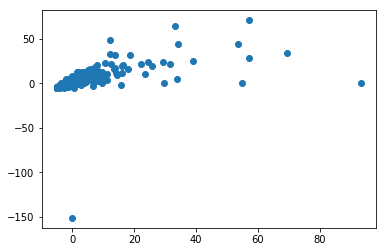

In [28]:
plt.scatter(ratings_pivot_std_pca__[:,0:1], ratings_pivot_std_pca__[:,1:])

In [29]:
#ratings_pivot_std_pca[:,0:1]
ratings_pivot_std_pca__

array([[-4.79133171, -4.9149598 ],
       [-4.09977729, -4.05508071],
       [-4.37580242, -3.67423257],
       ...,
       [-4.3120599 , -4.2146247 ],
       [-4.61501874, -4.63954513],
       [-2.84604459, -2.70281655]])

In [30]:
# kmeans clustering 
kmean = cluster.KMeans(n_clusters=10, max_iter=300, random_state=4000)
kmean.fit(ratings_pivot_std_pca__)
# add lebel to user table 
df_ratings_pivot_std['group'] = kmean.labels_
#df_train['group'] = kmean.labels_

In [31]:
df_ratings_pivot_std.group.value_counts()

9    380
0    157
6     74
5     32
1     15
4      4
3      4
8      3
7      1
2      1
Name: group, dtype: int64

In [32]:
len(df_ratings_pivot_std)

671

In [33]:
len(kmean.labels_)

671

In [34]:
pd.DataFrame(kmean.labels_)[0].value_counts()

9    380
0    157
6     74
5     32
1     15
4      4
3      4
8      3
7      1
2      1
Name: 0, dtype: int64

In [35]:
df_ratings_pivot_std

,1,2,3,4,5,6,7,8,9,10,...,65465,98243,131013,32728,32735,32743,98279,65514,98296,group
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.728836,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,-0.457798,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,9
2,-0.728836,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,2.460803,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,9
3,-0.728836,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,-0.457798,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,9
4,-0.728836,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,2.460803,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,6
5,-0.728836,-0.419317,3.889680,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,-0.457798,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,0
6,-0.728836,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,-0.457798,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,9
7,0.805034,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,1.731152,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,9
8,-0.728836,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,-0.457798,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,0
9,1.316324,-0.419317,-0.290461,-0.131306,-0.288993,-0.417236,-0.276688,-0.080773,-0.169829,-0.457798,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,9


In [36]:
df_ratings_pivot_std.shape

(671, 9067)

In [37]:
df_ratings.shape

(100004, 4)

In [38]:
df_ratings_pivot_std[df_ratings_pivot_std.group==7]

,1,2,3,4,5,6,7,8,9,10,...,65465,98243,131013,32728,32735,32743,98279,65514,98296,group
userId,,,,,,,,,,,,,,,,,,,,,
564,1.316324,2.672571,2.844645,-0.131306,2.889933,0.275748,2.924307,-0.080773,-0.169829,1.731152,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,7


In [39]:
#df_ratings_pivot_std.sum()

In [40]:
df_ratings_pivot_std.group.value_counts()

9    380
0    157
6     74
5     32
1     15
4      4
3      4
8      3
7      1
2      1
Name: group, dtype: int64

In [41]:
df_ratings_pivot.head(10)

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    4.0   
3          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    4.0   
5          NaN    NaN    4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
6          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7          3.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    3.0   
8          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
9          4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
10         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

         ...                                                                   \
movieId  ...   161084 161155 161594 161830 161918 161944 162376 162542 162672   
userId   ...                                                                    
1        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
6        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
8        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
9        ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
10       ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 163949  
userId          
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  
6          NaN  
7          NaN  
8          NaN  
9          NaN  
10         NaN  

[10 rows x 9066 columns]

In [42]:
df_ratings_pivot_std.groupby('group').mean()

,1,2,3,4,5,6,7,8,9,10,...,98230,65465,98243,131013,32728,32735,32743,98279,65514,98296
group,,,,,,,,,,,,,,,,,,,,,
0,0.049497,0.038558,0.025712,0.013516,-0.005522,-0.088400,-0.035424,0.028242,0.026030,-0.151066,...,-0.038633,-0.038633,-0.038633,0.126481,0.126481,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633
1,0.839120,0.637078,-0.046619,0.058170,0.594042,0.783936,0.221245,-0.080773,0.312522,0.296173,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633
2,1.060679,-0.419317,-0.290461,-0.131306,-0.288993,1.315223,1.857309,-0.080773,-0.169829,-0.457798,...,25.884358,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,25.884358
3,0.932857,0.546898,-0.290461,-0.131306,1.830291,0.968731,1.590559,-0.080773,-0.169829,0.727883,...,-0.038633,6.442115,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633
4,1.124591,0.353655,0.623945,-0.131306,0.505738,2.268076,1.323810,2.771784,-0.169829,0.636677,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633
5,0.477489,0.595209,0.330029,0.268370,0.158043,0.481477,0.373514,-0.080773,-0.000253,0.499868,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,0.771460,-0.038633,-0.038633,-0.038633,-0.038633
6,0.549389,0.369323,0.126141,0.233563,0.004556,0.238289,0.134250,0.073419,-0.023168,0.375383,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633
7,1.316324,2.672571,2.844645,-0.131306,2.889933,0.275748,2.924307,-0.080773,-0.169829,1.731152,...,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633,-0.038633
8,0.805034,0.224826,-0.290461,-0.131306,-0.288993,0.622240,-0.276688,-0.080773,-0.169829,0.271852,...,-0.038633,-0.038633,8.602364,-0.038633,-0.038633,-0.038633,8.602364,-0.038633,-0.038633,-0.038633


In [43]:
df_ratings_pivot_std.shape

(671, 9067)

In [44]:
print(pca.explained_variance_ratio_) 

[0.08237841 0.05046116]


In [45]:
print(pca.singular_values_)  

[707.90637809 554.04845303]
